# Classifier Model

Create Path to Import *.py files (not needed in "index.ipynb")

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### sklearn libraries

In [81]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, make_scorer, roc_auc_score,accuracy_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import * #
from imblearn.pipeline import Pipeline
from yellowbrick.classifier import ConfusionMatrix
from codes.preprocess import *
from codes.model import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.options.display.max_columns = None

In [3]:
# Load Test Data
X_test, y_test = load_clean_data('test')

In [ ]:
# sample to smaller dataset

#### Load clean train data.

In [4]:
X_train, y_train = load_clean_data('train')

In [54]:
y_train.sum()

40648

In [5]:
df = pd.concat([X_train,y_train],axis=1)
df = pd.concat([df[df.delinquency_bool==1],
                df[df.delinquency_bool==0].sample(n=y_train.sum(), random_state=42)],axis=0)

In [6]:
X_train = df.drop(columns=['delinquency_bool'])
y_train = df.delinquency_bool

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81296 entries, 56 to 367755
Data columns (total 13 columns):
org_balance           81296 non-null int64
interest_rate         81296 non-null float64
ltv                   81296 non-null int64
borrower_count        81296 non-null int64
score                 81296 non-null float64
loan_purpose          81296 non-null object
dti                   81296 non-null float64
occupancy_type        81296 non-null object
property_type         81296 non-null object
upc_balance           81296 non-null float64
loan_age              81296 non-null int64
months_to_maturity    81296 non-null int64
payment_amounts       81296 non-null float64
dtypes: float64(5), int64(5), object(3)
memory usage: 8.7+ MB


In [5]:
# Testing pipe and grid with subset of 5000.

# Xp_train = X_train[0:5000].fillna(0)
# yp_train = y_train[0:5000]

In [7]:
y_train.value_counts()

1    40648
0    40648
Name: delinquency_bool, dtype: int64

/Users/jleifnf/Library/Python/3.7/lib/python/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/jleifnf/Library/Python/3.7/lib/python/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


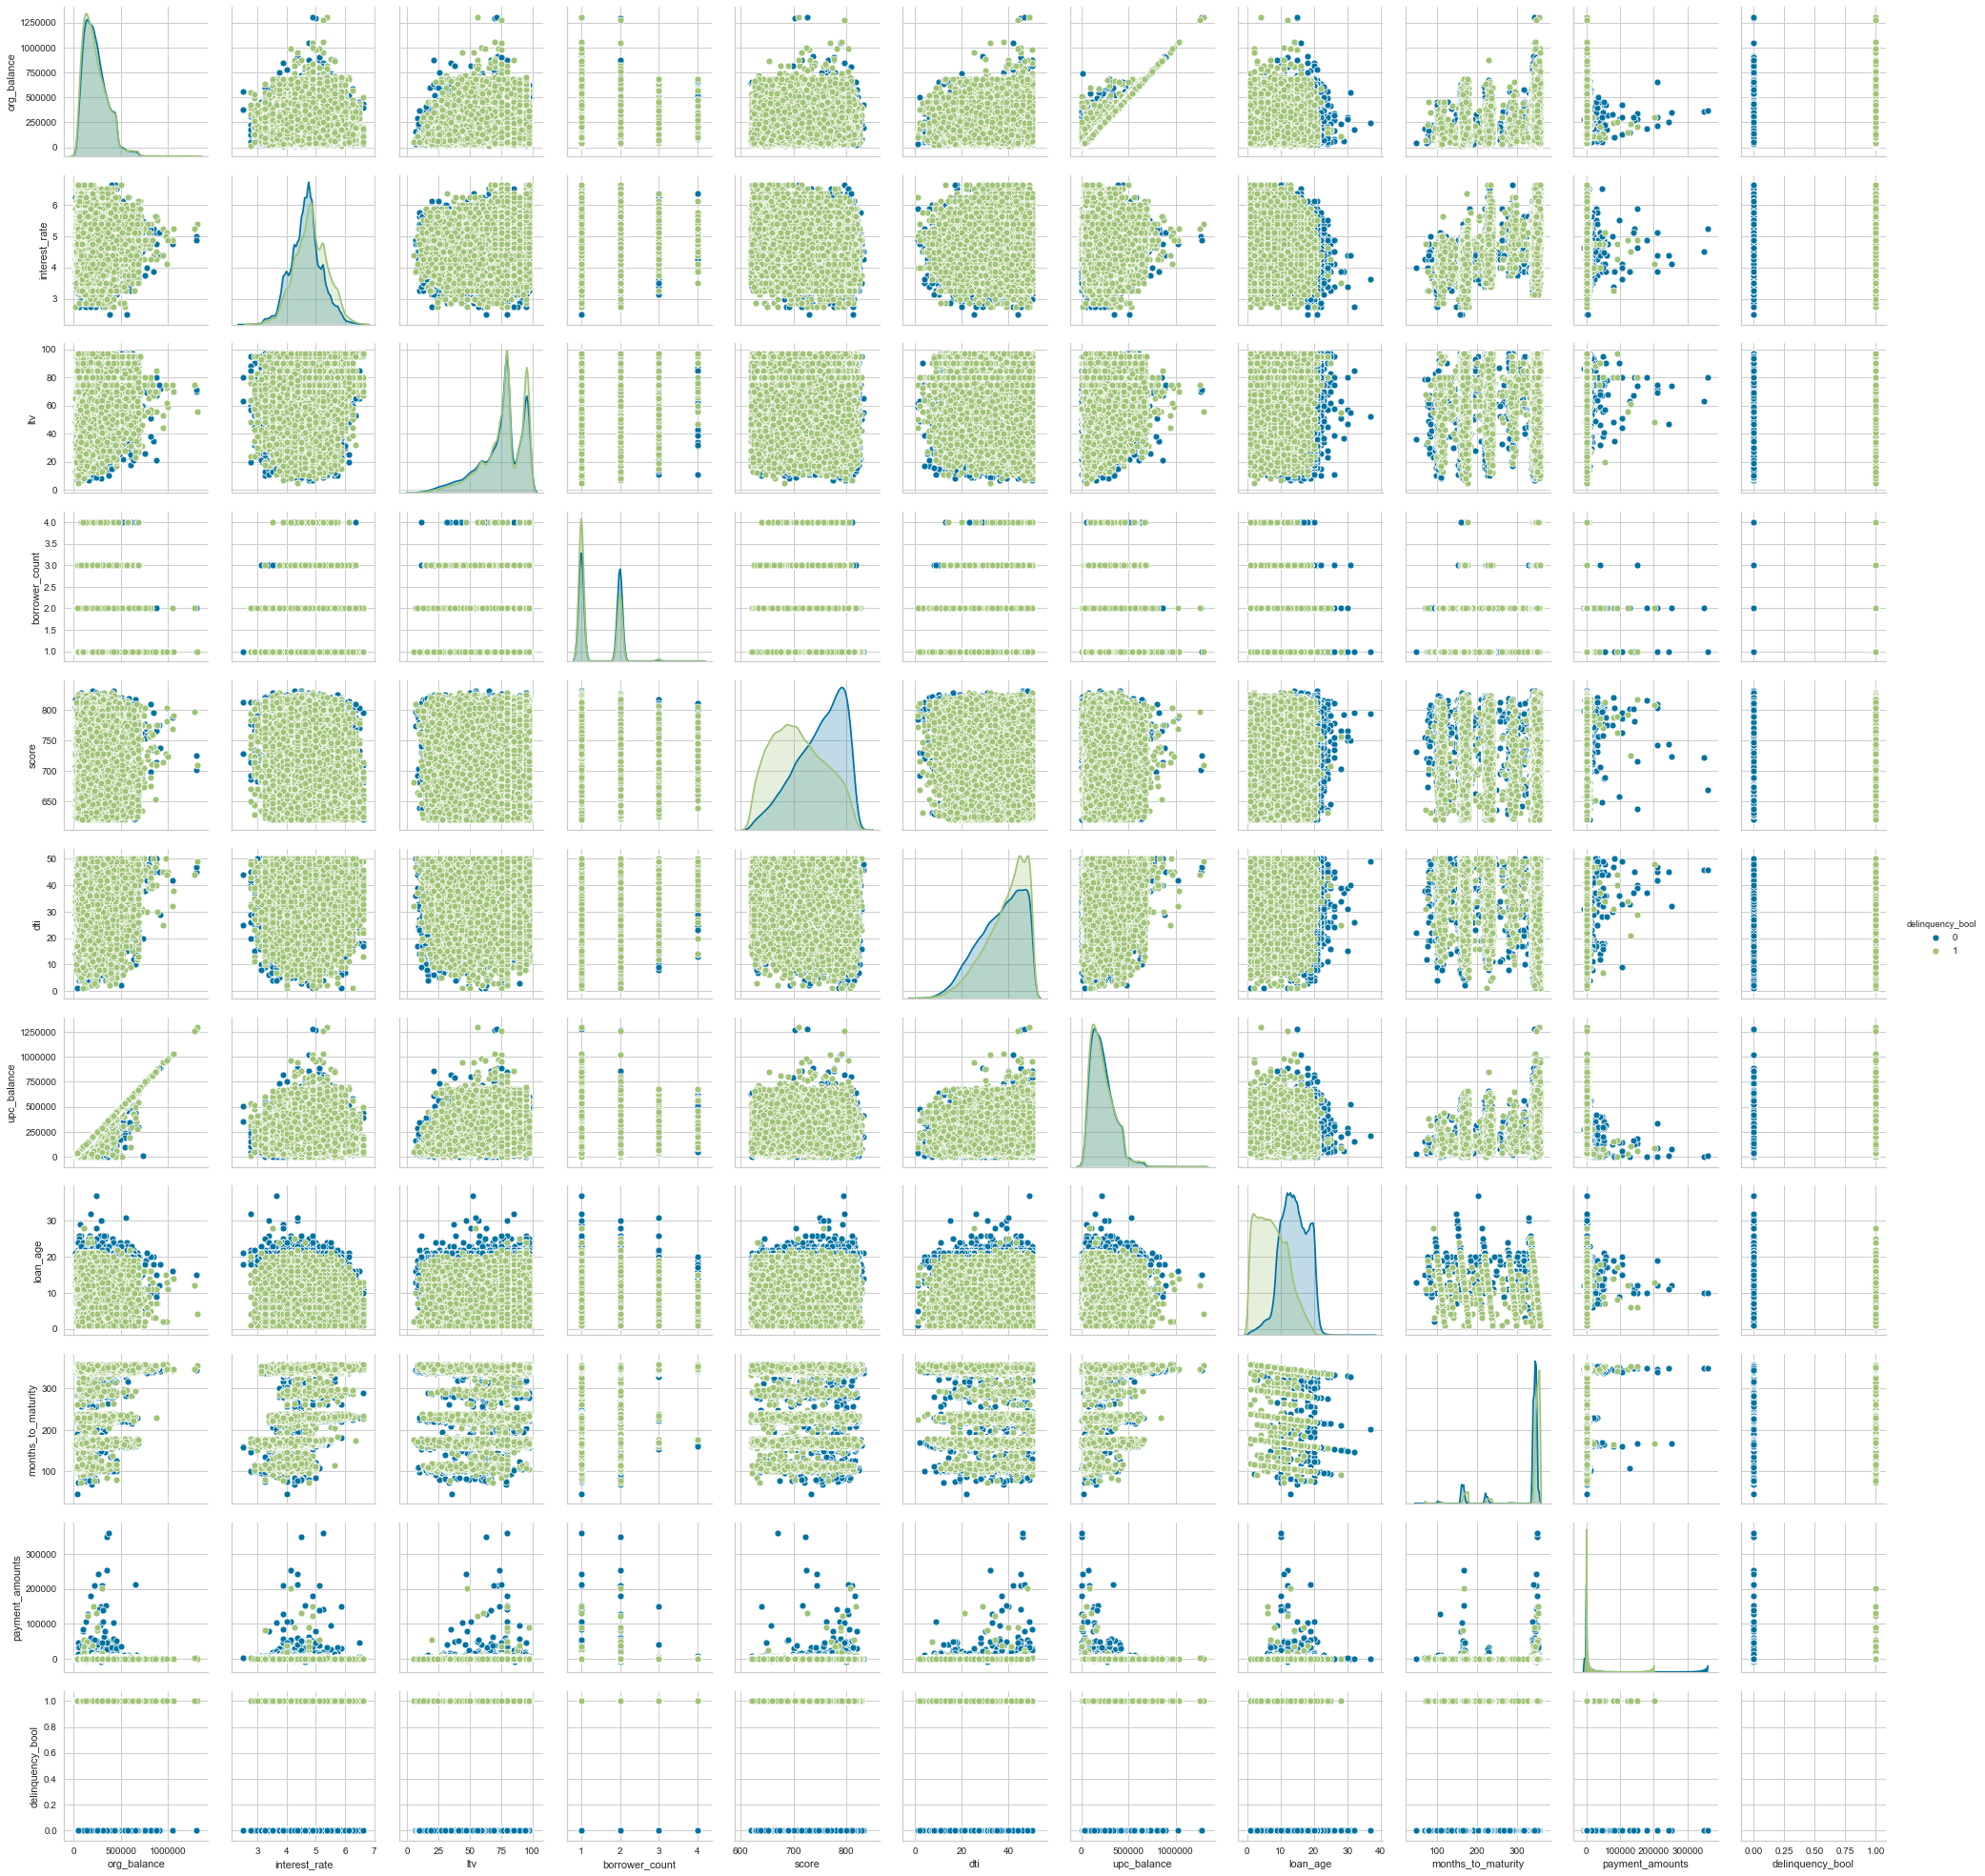

In [10]:
sns.pairplot(df, hue='delinquency_bool');

#### Preprocessor (StandardScaler and OneHotEncoder)

In [11]:
categ_cols = X_train.columns[X_train.dtypes==object].tolist()
numeric_cols = X_train.columns[X_train.dtypes!=object].tolist()

In [12]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categor', categorical_transformer, categ_cols)
    ]
)

#### Build a base pipeline (No SMOTE).

In [14]:
preprocessor = build_transformers(X_train)

In [15]:
base_pipe = Pipeline([
     ('prep', preprocessor),
     ('clf', LogisticRegression(n_jobs=-2))
], memory='cached_transformers')

In [12]:
base_pipe.fit(X_train,y_train);

#### Validate Base Model (LogisticRegression)

In [30]:
def CM(pipe, X, y):
    delinq_cm = ConfusionMatrix(pipe, 
                            classes=['Current','Delinquent'],
                            label_encoder={0: 'Current', 1: 'Delinquent'},
                            is_fitted=True, percent=True
                            )
    delinq_cm.score(X, y)
    delinq_cm.show()
    print(classification_report(y, pipe.predict(X), target_names=['Current','Delinquent'], digits=4))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/jleifnf/Library/Python/3.7/lib/python/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


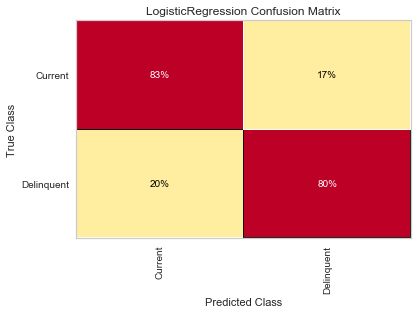

array([[426215,  84456],
       [  3905,  16115]])

              precision    recall  f1-score   support

     Current     0.9909    0.8346    0.9061    510671
  Delinquent     0.1602    0.8049    0.2673     20020

    accuracy                         0.8335    530691
   macro avg     0.5756    0.8198    0.5867    530691
weighted avg     0.9596    0.8335    0.8820    530691



In [13]:
CM(base_pipe, X_test, y_test)

#### Base RandomForest

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/jleifnf/Library/Python/3.7/lib/python/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


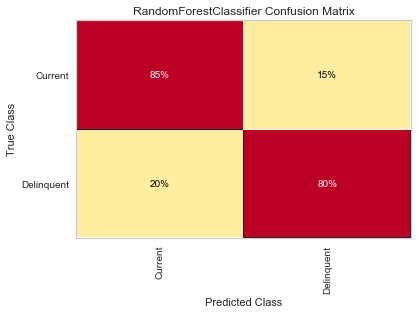

array([[434972,  75699],
       [  4039,  15981]])

              precision    recall  f1-score   support

     Current     0.9908    0.8518    0.9160    510671
  Delinquent     0.1743    0.7983    0.2861     20020

    accuracy                         0.8497    530691
   macro avg     0.5826    0.8250    0.6011    530691
weighted avg     0.9600    0.8497    0.8923    530691



In [14]:
rf_pipe = Pipeline([
     ('prep', preprocessor),
     ('clf', RandomForestClassifier())
], memory='cached_transformers')
rf_pipe.fit(X_train,y_train)
CM(rf_pipe, X_test, y_test)

#### Base GradientBoostClassifier (RandForest)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/jleifnf/Library/Python/3.7/lib/python/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


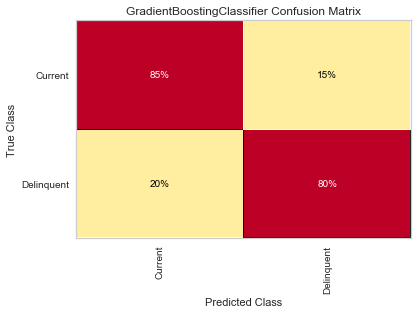

array([[435244,  75427],
       [  3975,  16045]])

              precision    recall  f1-score   support

     Current     0.9909    0.8523    0.9164    510671
  Delinquent     0.1754    0.8014    0.2878     20020

    accuracy                         0.8504    530691
   macro avg     0.5832    0.8269    0.6021    530691
weighted avg     0.9602    0.8504    0.8927    530691



In [26]:
gbc_pipe = Pipeline([
     ('prep', preprocessor),
     ('clf', GradientBoostingClassifier(random_state=42))
], memory='cached_transformers')
gbc_pipe.fit(X_train,y_train)
CM(gbc_pipe, X_test, y_test)

#### Base SGBClassifier Logistic Regression

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/jleifnf/Library/Python/3.7/lib/python/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


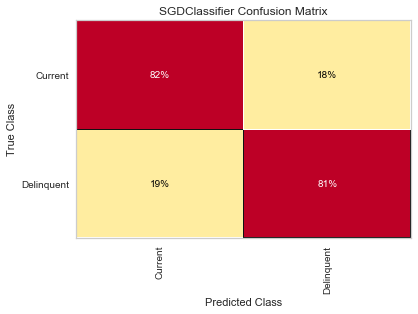

array([[417411,  93260],
       [  3730,  16290]])

              precision    recall  f1-score   support

     Current     0.9911    0.8174    0.8959    510671
  Delinquent     0.1487    0.8137    0.2514     20020

    accuracy                         0.8172    530691
   macro avg     0.5699    0.8155    0.5737    530691
weighted avg     0.9594    0.8172    0.8716    530691



In [36]:
sgb_pipe = Pipeline([
     ('prep', preprocessor),
     ('clf', SGDClassifier(loss='log', random_state=42))
], memory='cached_transformers')
sgb_pipe.fit(X_train,y_train)
CM(sgb_pipe, X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/jleifnf/Library/Python/3.7/lib/python/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


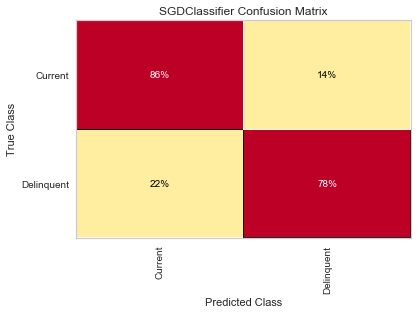

array([[437609,  73062],
       [  4376,  15644]])

              precision    recall  f1-score   support

     Current     0.9901    0.8569    0.9187    510671
  Delinquent     0.1764    0.7814    0.2878     20020

    accuracy                         0.8541    530691
   macro avg     0.5832    0.8192    0.6032    530691
weighted avg     0.9594    0.8541    0.8949    530691



In [40]:
sgb_pipe = Pipeline([
     ('prep', preprocessor),
     ('clf', SGDClassifier(loss='hinge', random_state=42))
], memory='cached_transformers')
sgb_pipe.fit(X_train,y_train)
CM(sgb_pipe, X_test, y_test)

#### Best Model LogisticRegression from RandomizedSearchCV

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/jleifnf/Library/Python/3.7/lib/python/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


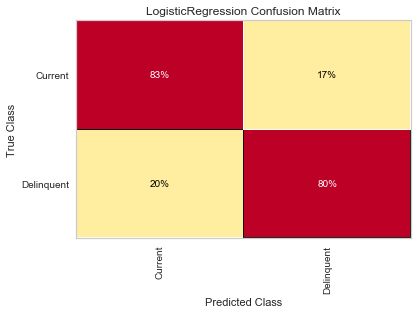

array([[426213,  84458],
       [  3904,  16116]])

              precision    recall  f1-score   support

     Current     0.9909    0.8346    0.9061    510671
  Delinquent     0.1602    0.8050    0.2673     20020

    accuracy                         0.8335    530691
   macro avg     0.5756    0.8198    0.5867    530691
weighted avg     0.9596    0.8335    0.8820    530691



In [18]:
log_pipe = Pipeline([
     ('prep', preprocessor),
     ('clf', LogisticRegression(C=10.0, class_weight=None, dual=False,
                         fit_intercept=True, intercept_scaling=1,
                         l1_ratio=None, max_iter=100000.0,
                         multi_class='auto', n_jobs=-2, penalty='l2',
                         random_state=42, solver='lbfgs', tol=0.0001,
                         verbose=0, warm_start=False))
], memory='cached_transformers')
log_pipe.fit(X_train,y_train)
CM(log_pipe, X_test, y_test)

#### Best RandomForestClassifier from RandomizedSearchCV

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/jleifnf/Library/Python/3.7/lib/python/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


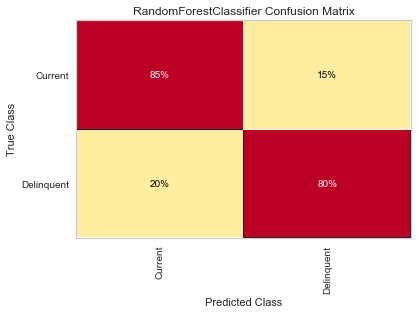

array([[434797,  75874],
       [  3925,  16095]])

              precision    recall  f1-score   support

     Current     0.9911    0.8514    0.9159    510671
  Delinquent     0.1750    0.8039    0.2874     20020

    accuracy                         0.8496    530691
   macro avg     0.5830    0.8277    0.6017    530691
weighted avg     0.9603    0.8496    0.8922    530691



In [19]:
brf_pipe = Pipeline([
     ('prep', preprocessor),
     ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=50, max_features=4, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=1000,
                        n_jobs=-2, oob_score=False, random_state=42, verbose=0,
                        warm_start=False))
], memory='cached_transformers')
brf_pipe.fit(X_train,y_train)
CM(brf_pipe, X_test, y_test)

#### RandomSearchCV over GradientBoostClassifier

In [37]:
param_grid = dict(
#                 clf__learning_rate=np.logspace(-1,-3,3),
                clf__max_depth=[50,100], 
                clf__max_features=[4,8])
rand_gbc = RandomizedSearchCV(gbc_pipe, param_grid,  scoring='accuracy', n_iter=10, n_jobs=-2, cv=5, random_state=2020)
rand_gbc.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory='cached_transformers',
                                      steps=[('prep',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('numeric',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scaler',
                                                                                                StandardScaler(copy=True,
                                                                                  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/jleifnf/Library/Python/3.7/lib/python/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


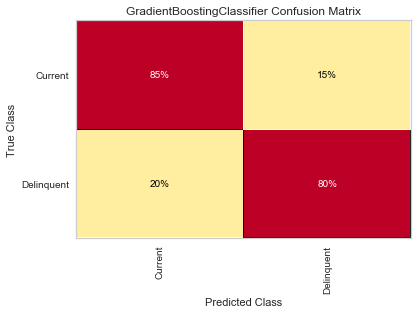

[[431569  79102]
 [  3950  16070]]
              precision    recall  f1-score   support

     Current     0.9909    0.8451    0.9122    510671
  Delinquent     0.1689    0.8027    0.2790     20020

    accuracy                         0.8435    530691
   macro avg     0.5799    0.8239    0.5956    530691
weighted avg     0.9599    0.8435    0.8883    530691



In [34]:
bgbc_pipe = Pipeline([
     ('prep', preprocessor),
     ('clf', GradientBoostingClassifier(n_estimators=1000,max_features=4,max_depth=100,random_state=42))
], memory='cached_transformers')
bgbc_pipe.fit(X_train,y_train)
CM(bgbc_pipe, X_test, y_test)

#### RandomSearchCV over SGDClassifier

In [ ]:
param_grid = dict(
#                 clf__learning_rate=np.logspace(-1,-3,3),
                clf__max_depth=[50,100], 
                clf__max_features=[4,8])
rand_sgb = RandomizedSearchCV(sgb_pipe, param_grid,  scoring='accuracy', n_iter=10, n_jobs=-2, cv=5, random_state=2020)
rand_sgb.fit(X_train, y_train)

/Users/jleifnf/Library/Python/3.7/lib/python/site-packages/imblearn/pipeline.py:242: UserWarning: Persisting input arguments took 0.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name]


              precision    recall  f1-score   support

     Current       0.99      0.83      0.91    510671
  Delinquent       0.16      0.80      0.27     20020

    accuracy                           0.83    530691
   macro avg       0.58      0.82      0.59    530691
weighted avg       0.96      0.83      0.88    530691



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/jleifnf/Library/Python/3.7/lib/python/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


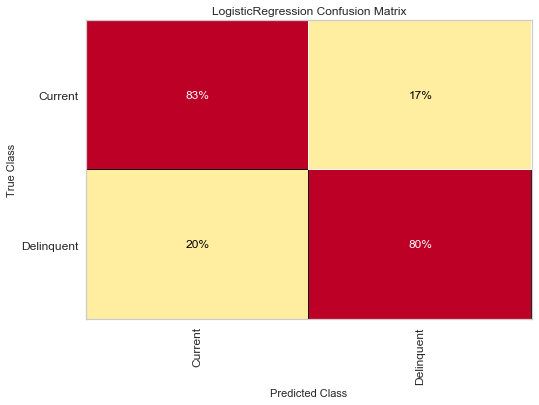

In [63]:
smote_pipe = Pipeline([
     ('prep', preprocessor),
#      ('smote', SMOTE(random_state=2020, n_jobs=-2)),
     ('clf', LogisticRegression(n_jobs=-2))
], memory='cached_transformers')
smote_pipe.fit(X_train,y_train);
CM(smote_pipe,X_test,y_test)

RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)

LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

### GridSearch over which Base Model is best

In [ ]:
param_grid = dict(clf=[LogisticRegression(solver='lbfgs',n_jobs=-2,random_state=42),
                       LogisticRegression(solver='saga',n_jobs=-2,random_state=42),
                       GradientBoostingClassifier(max_depth=1000,random_state= 42),
                       RandomForestClassifier(max_depth=1000,n_jobs=-2,random_state=42),
                       SGDClassifier(loss='hinge',n_jobs=-2, random_state=42),
                       SGDClassifier(loss='log',n_jobs=-2, random_state=42),
                       SVC(gamma = 'auto', random_state=42),
                      ]
    )
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)
accuracy_scorer = make_scorer(accuracy_score)
grid_cv = GridSearchCV(base_pipe, param_grid,  
                       scoring={'acc':accuracy_scorer, "roc_auc":roc_auc_scorer},
                       refit='acc', n_jobs=-2, cv=5)
grid_cv.fit(X_train, y_train);

In [31]:
grid_cv.best_estimator_

Pipeline(memory='cached_transformers',
         steps=[('prep',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['org_balance',
                                                   'interest_rate', 'ltv',
                                   

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/jleifnf/Library/Python/3.7/lib/python/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


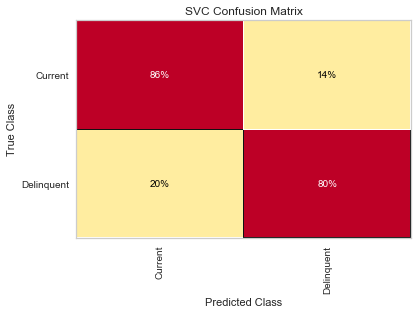

[[436645  74026]
 [  3938  16082]]
              precision    recall  f1-score   support

     Current     0.9911    0.8550    0.9180    510671
  Delinquent     0.1785    0.8033    0.2921     20020

    accuracy                         0.8531    530691
   macro avg     0.5848    0.8292    0.6051    530691
weighted avg     0.9604    0.8531    0.8944    530691



In [33]:
CM(grid_cv.best_estimator_,X_test,y_test)

RandomizedSearchCV over parameters of LogisticRegression gave the following model:<br>

     LogisticRegression(C=10.0, class_weight=None, dual=False,
                         fit_intercept=True, intercept_scaling=1,
                         l1_ratio=None, max_iter=100000.0,
                         multi_class='auto', n_jobs=-2, penalty='l2',
                         random_state=42, solver='lbfgs', tol=0.0001,
                         verbose=0, warm_start=False)

GridSearchCV over Base Models gave the SVC as the best using accuracy and roc_auc metrics.

### Feature Importance from GradientBoostingClassifier

In [61]:
bgbc_pipe['prep'].transformers_[1][1]['onehot'].categories_

[array(['C', 'P', 'R'], dtype=object),
 array(['I', 'P', 'S'], dtype=object),
 array(['CO', 'CP', 'MH', 'PU', 'SF'], dtype=object)]

In [82]:
feat_importance = pd.DataFrame(zip([c.replace('_',' ').title() for c in numeric_cols]
                                   + ['C', 'P', 'R'] +['I', 'P', 'S'] 
                                   + ['CO', 'CP', 'MH', 'PU', 'SF'],
                                   bgbc_pipe['clf'].feature_importances_))
feat_importance.columns = ['Features', 'Importance']

In [87]:
from codes.fig_generate import *

In [ ]:
ax_p

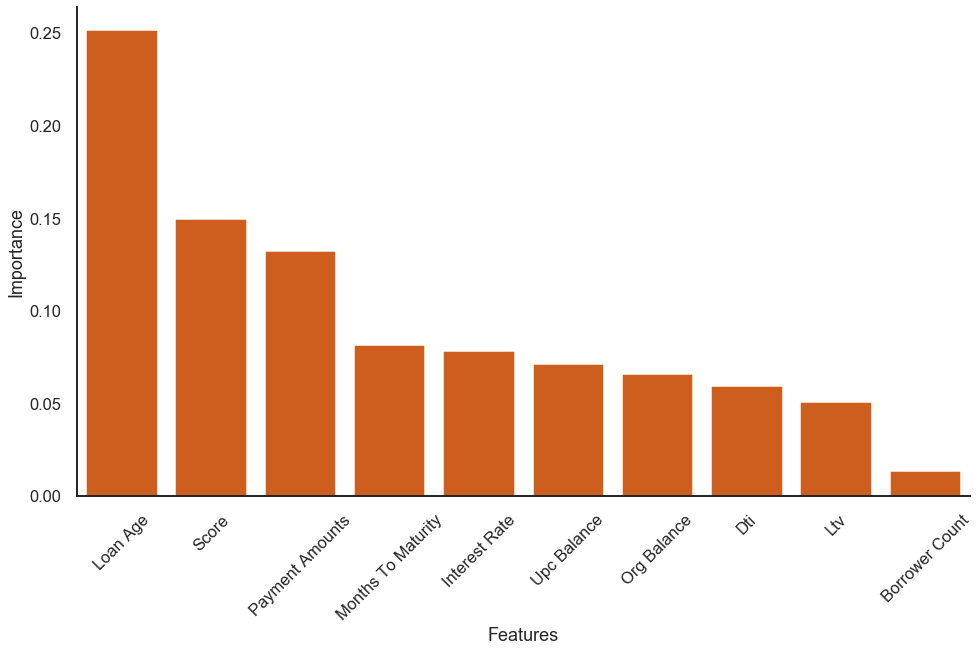

In [90]:
sns.set(style="white", context='talk')
sns.set_palette('dark')
fig ,ax = plt.subplots(1,1,figsize=(16,9))
sns.barplot(x='Features',y='Importance',color='#eb5600',
            data=feat_importance.sort_values(by='Importance',ascending=False)[:10], ci=None)
ax_params('Features', 'Importance', plt_title='Feature_Importance', savefig=True)

### Accuracy:
- Base Models:
    - LogisticRegression: 0.8335
    - RandomForest: 0.8497
    - GradientBoostingClassifier: 0.8504
    - SGDClassifier(‘log’): 0.8172
    - SGDClassifier(‘hinge’): **0.8541**
    - SVC: 0.8531
- Best Models?
    - LogisticRegression: 0.8335
    - RandomForest: 0.8496
    - GradientBoostingClassifier: 0.8435
    - SGDClassifier(‘hinge’): ?